# <font color=red>Théorie de la ruine : simulation du modèle de Cramer-Lundberg via la simulation et l'inférence d'un processus de Poisson </font>

<div style="text-align: right"> 
Sorbonne Université, Master 1
</div>
<div style="text-align: right">
Dans ce projet, la partie centrale restera la branche mathématique des assurances toutefois cela se rapproche par beaucoup de similitudes d'un des sujets proposés sur moodle.  
</div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns
import warnings
sns.set_theme()
warnings.filterwarnings("ignore")

# Sommaire
1. [Introduction](#part1)
2. [Simulation du processus de Poisson (PP)](#part2)
    - [PP Homogène](#part1sec2)
    - [PP Inhomogène](#part1sec3)
2. [Inférence pour le processus de Poisson](#part3)
    - [PP Homogène](#part2sec1)
    - [PP Inhomogène](#part2sec2)
3. [Théorie de la ruine : Modèle de Cramer-Lundberg](#part4)
    - [Démonstration mathématique](#part3sec1)
    - [Simulation](#part3sec2)

# Introduction

Dans le cadre d'une étude des risques financiers sur une compagnie d'assurance c'est surtout la probabilité que
cette compagnie d'assurance soit en faillite. Il s'agit lors de notre étude d'implémenter des fonctions pour simuler, estimer et diagnostiquer des processus de Poisson. D’autres concepts statistiques sont également explorés : complexité algorithmique, étude de simulation, graphique quantile-quantile.

Avant de pouvoir nous avancer directement vers cette optique il faut d'abord comprendre de quoi l'on parle, c'est là que dans le risque de ruine il faut générer les sinistres qui sont modélisés par un processus de Poisson homogène, il faut également prendre en compte le fait qu'il y a chevauchement entre les sauts, le temps entre deux sinistres est une loi exponentielle.
C'est pour cela que nous allons d'abord modéliser la simulation d'un processus de poisson puis l'inférence pour ce dernier.

Toutefois vis à vis de la vie réelle, les instants du sinistre dépendent du temps c'est pour cela que nous le ferons également à partir d'un processus de Poisson inhomogène.

# Simulation d'un processus de Poisson (PP)

## PP Homogène

On considère un processus de Poisson $(N_t)_{t\geq0}$ d’intensité $\lambda$ > 0. Par ailleurs, T > 0 désigne un réel positif et
${n\geq0}$ un entier positif. C'est simplement dire qu'une loi de poisson est de paramètre $\lambda$t.

Pour simuler le processus de Poisson, nous allons utiliser la proposition selon laquelle si $N_t$ pour $t\geq0$ suit
une loi PPP(λ) où λ > 0, alors ses temps d’attentes sont indépendants et de loi $\epsilon(\lambda)$. Pour nos algorithmes
nous utiliserons le fait que $T_n = \sum_{i=1}^{n} X_i$ où $T_n$ est la suite des instants de saut du processus de poisson et
$X_n$, la suite des temps d’attente.

In [4]:
def instants_saut(intensity,n):
    A = np.zeros(n+1)
    x = np.random.exponential(scale=1/intensity,size=n)
    for k in range(1,n+1):
        A[k] = np.sum(x[0:k])
    return np.array(A)

def tps_att(intensity,T):
    attente = []
    while sum(attente)<T:
        attente.append(np.random.exponential(scale=1/intensity))
    return attente[:-1]

def instant_saut(intensity,T):
    attente = tps_att(intensity,T)
    instants = np.cumsum(attente)
    return instants

def processus_poisson(intensity,n,T):
    A = [0]
    x = np.random.exponential(scale=1/intensity,size=n)
    tps_total = 0
    for i in range(n):
        tps_total += x[i]
        if tps_total>T:
            break
        A.append(tps_total)
    return np.array(A)

In [5]:
T = 10
n = 10
intensity = 1
Liste_A = processus_poisson(intensity,n,T)
Liste_A

array([0.        , 2.00217653, 4.78875111, 5.75335959, 7.06658581,
       8.25442167, 8.5204043 , 9.49341136, 9.99750512])

Les résultats du PPP sont croissants ce qui est cohérent.

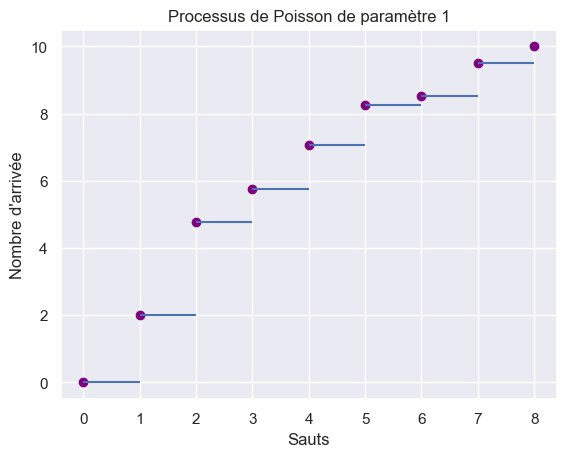

In [6]:
indices = np.arange(len(Liste_A))
plt.hlines(Liste_A[:-1],indices[:-1],indices[1:])
plt.scatter(indices,Liste_A,color="purple",marker='o')
plt.xlabel("Sauts")
plt.ylabel("Nombre d'arrivée")
plt.title(f"Processus de Poisson de paramètre {intensity}")
plt.show()

## PP Inhomogène

On génère un processus de Poisson inhomogène ${N(t),t\geq0}$ d'intensité $\lambda(t)$ sur $t \in [0,T]$.
On choisit $\lambda_{max}$ tel que $\lambda(t) < \lambda_{max}$ pour tout $t \in [0,T]$. La probabilité de thinning est p(t)=$\frac{\lambda(t)}{\lambda_{max}}$



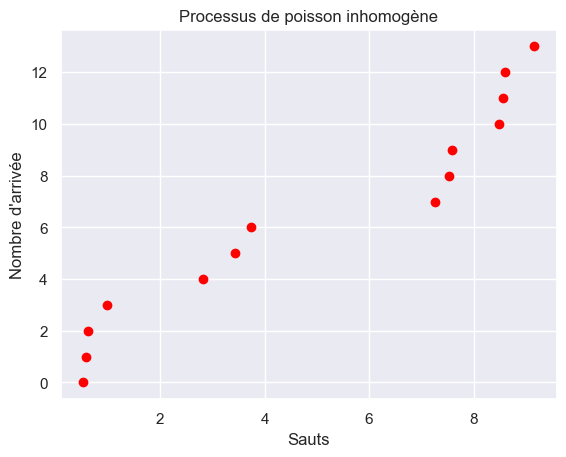

In [7]:
def lambda_t(t): # la fonction doit être continue, bornée
    return 1+np.sin(t)

def processus_thinning(lambda_max, T):
    instants = []
    t = 0
    while t<T:
        t += np.random.exponential(scale=1/lambda_max)
        if t>=T:
            break
        if np.random.uniform(0,1)<lambda_t(t)/lambda_max:
            instants.append(t)
    return np.array(instants)
lambda_max = 3
instants_sauts = processus_thinning(lambda_max,T)
plt.scatter(instants_sauts,np.arange(len(instants_sauts)),color="red",marker="o")
plt.xlabel("Sauts")
plt.ylabel("Nombre d'arrivée")
plt.title("Processus de poisson inhomogène")
plt.show()

#  Inférence pour le processus de Poisson

## PP Homogène

$N_t \to PPP(\lambda)$, $N_T = n$, n > 0
Par maximum de vraisemblance, on a : $\tilde \lambda = \frac{N_T}{T}$. Par le théorème centrale limite et en passant par la
fonction caractéristique de l’estimateur de $\lambda$, $\tilde \lambda$ ~ N(0,$\lambda$) Intervalle de confiance asymptotique au niveau 1 

α : $IC_1 −\alpha = [\lambda ±(u_1 −\frac{\alpha}{2})*(\frac{\lambda}{T})]$

In [8]:
def intervalle_asymptotique(intensity,n,T,alpha):
    lambda_estimateur=n/T
    z_alpha=norm.ppf(1-alpha/2)
    erreur=np.sqrt(lambda_estimateur)/T
    intervalle=[lambda_estimateur-z_alpha*erreur,lambda_estimateur+z_alpha*erreur]
    return lambda_estimateur,intervalle

In [9]:
N=np.arange(0,50,10)
T=[3,5,10,15,20]

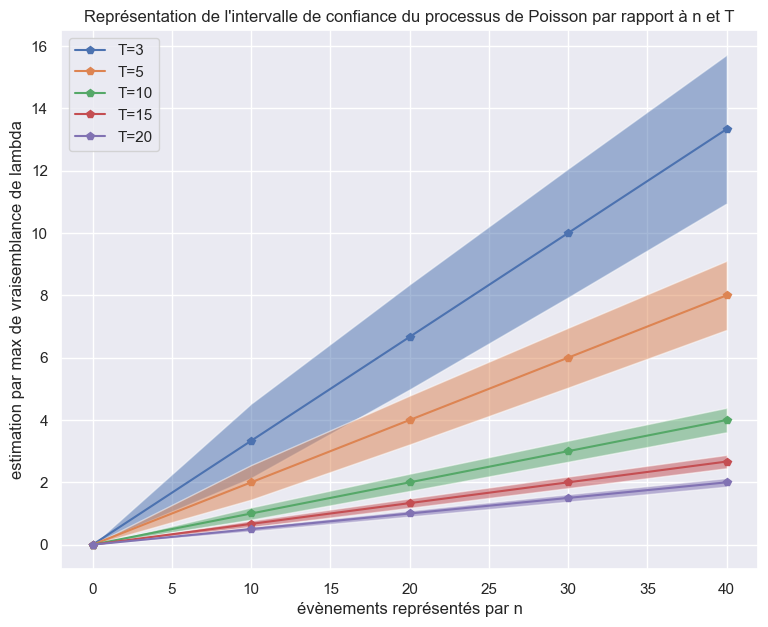

In [10]:
plt.figure(figsize=(9,7))
for t in T:
    lambdas=[]
    borne_inf=[]
    borne_sup=[]
    for n in N:
        lambda_estimateur,intervalle = intervalle_asymptotique(intensity=2, n=n, T=t,alpha=0.05)
        lambdas.append(lambda_estimateur)
        borne_inf.append(intervalle[0])
        borne_sup.append(intervalle[1])
    plt.plot(N,lambdas,marker="p",label=f"T={t}")
    plt.fill_between(N,borne_inf,borne_sup,alpha=0.5)
plt.xlabel("évènements représentés par n")
plt.ylabel("estimation par max de vraisemblance de lambda")
plt.title("Représentation de l'intervalle de confiance du processus de Poisson par rapport à n et T")
plt.legend()
plt.show()

In [11]:
n = 1000
lambd = 2
x = np.random.poisson(lam=lambd,size=n)

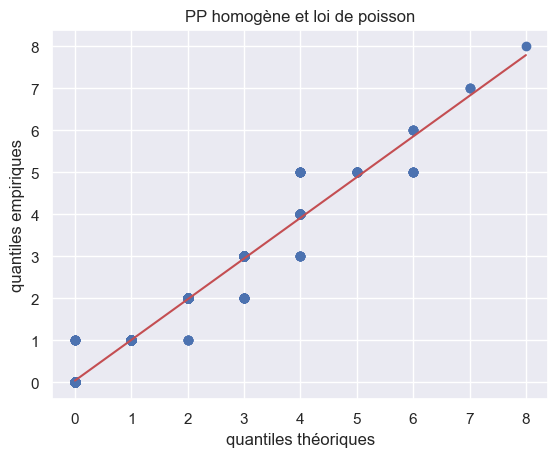

In [12]:
stats.probplot(x,dist="poisson",sparams=(lambd,),plot=plt)
plt.title("PP homogène et loi de poisson")
plt.xlabel("quantiles théoriques")
plt.ylabel("quantiles empiriques")
plt.show()

## PP Inhomogène

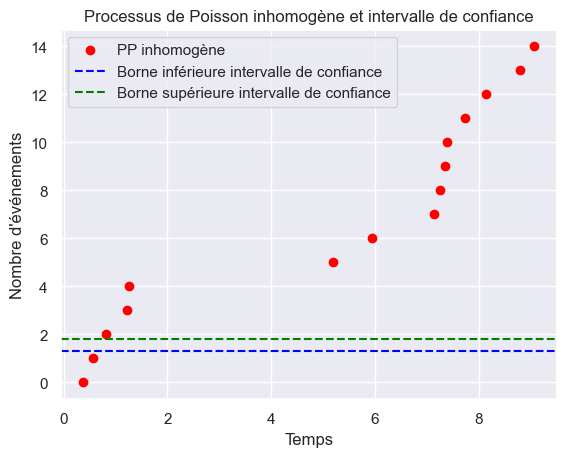

In [13]:
def intervalle_asymptotique_inhomogene(lambda_max,T,alpha):
    instants_sauts = processus_thinning(lambda_max, T)
    n = len(instants_sauts)
    moyenne_lambda = np.mean([lambda_t(t) for t in instants_sauts])
    z_alpha = norm.ppf(1-alpha/2)
    erreur = np.sqrt(moyenne_lambda)/T
    intervalle = [moyenne_lambda-z_alpha*erreur,moyenne_lambda+z_alpha*erreur]
    return moyenne_lambda,intervalle,instants_sauts

T = 10
lambda_max = 2
alpha = 0.05
moyenne_lambda,intervalle,instants_sauts =intervalle_asymptotique_inhomogene(lambda_max,T,alpha)

plt.scatter(instants_sauts,np.arange(len(instants_sauts)),color='red',label="PP inhomogène")
plt.axhline(y=intervalle[0],color='blue',linestyle='dashed',label="Borne inférieure intervalle de confiance")
plt.axhline(y=intervalle[1],color='green',linestyle='dashed',label="Borne supérieure intervalle de confiance")
plt.xlabel("Temps")
plt.ylabel("Nombre d'événements")
plt.title("Processus de Poisson inhomogène et intervalle de confiance")
plt.legend()
plt.show()

Ce n'est pas étonnant lorsque l'on évalue la trajectoire d'un PP homogène quel que soit l'instant de saut,
le processus est dans son intervalle de confiance. A l'inverse d'un PP inhomogène et nous verrons que lorsque nous travaillerons sur la théorie de ruine, la compagnie d'assurance va très rapidement entrer en état de ruine ce qui est réaliste si les sinistres sont très nombreux c'est pour cela que pour éviter ce scénario on augmentera le capital initial qu'on verra plus tard.

# Théorie de la ruine : Modèle de Cramer-Lundberg

## Démonstration mathématique

Une compagnie d’assurance souhaite modéliser les réserves dont elle dispose au cours du temps. Pour cela, on
considère que des sinistres se produisent selon un processus de Poisson $(N_t)_{t\geq0}$ d’intensité $\lambda \geq 0$, dont les instants
de saut seront notés $(T_1,T_2,...)$ et les temps d’attente $(X_1,X_2,...)$. Les montants des remboursements associés
aux sinistres peuvent être décrits par la suite $(W_n)_{n\geq0}$ de variables aléatoires i.i.d. d’espérance $E[W_1] = 1/\beta$
pour tout $n \geq 1$. On suppose que les montants des remboursements sont indépendants des instants de sinistres.

# 1)

Les $(N_t)_{t\geq0}$ sont indépendants, ce qui caractérise un processus de Poisson.  
Puis, pour $S_t = \sum_{i=1}^{N_t} W_i$, les sauts du processus sont des variables $W_i$ qui sont indépendantes et identiquement distribuées iid.  
C'est une propriété fondamentale pour un processus de Poisson composé.

La compagnie d’assurance possède à t = 0 un capital $u \geq 0$ et encaisse des primes d’un montant de c > 0 par unité de temps. Le processus des réserves $(R_t)_{t \geq 0}$ de la compagnie est donc donné par le modèle suivant de Cramer-Lundberg :

$R_t = u + c t - S_t$ où on déterminera l'expression de $S_t$

La théorie de ruine va s'appuyer sur la probabilité que la compagnie d'assurance ait une réserve en état de ruine c'est-à-dire :

$$\Psi(u) = P(t > 0 : R_t < 0)$$

---


\begin{equation*}
\ R_t = u + c t - S_t = u + c t - \sum_{i=1}^{N_t} W_i = u + c t - \sum_{i=1}^{N_t - 1} W_i - W_1
\end{equation*}

où :
- u : réserve initiale
- c : montant des primes perçues
- $N_t$ : processus de Poisson comptant les sinistres
- $W_i$ : montant des sinistres

Par la propriété des accroissements indépendants :


\begin{equation*}
\ N_t - 1 = N_t - N_{T_1} \sim N_{t-T_1}
\end{equation*}



On remarque que t est définie par :

\begin{equation*}
\ c t = c (t - T_1) + c T_1
\end{equation*}

On obtient :

$R_t = u + c (t - T_1) + c T_1 - \sum_{i=1}^{N_t - 1} W_i - W_1 = \widetilde{R_{t-T_1}} + (c T_1 - W_1)$

Il n'y a pas de chevauchements de sauts puis les $(W_i)_{i\geq0}$ sont iid ; les processus de réserves restent inchangés du fait que les 
$(X_2,X_3,...)$ sont les temps d'attente d'une loi exponentielle donc les processus de réserves restent inchangés.

---


# 2)

$$ E(\Psi(u + cT_{n} - W_{n})) = E(P(t>0: R_{t+T_{1}} < 0|T_{1}))$$


$$ R_{t + T_{1}} = u + c(t + T_{1}) - S_{t+T_{1}} = u + c(t + T_{1}) - \sum_{k = 1}^{N_t + T_{1}} W_{k} = (u + cT_{1} - W_{1}) + ct - \sum_{k =1}^{N_t + T_{1} - 1} W_{k}$$


$\text{or} \quad N_{t + T_{1}} - 1 = N_{t + T_{1}} - N_{T_{1}} \approx N_{t}$


$\text{et}\quad R_{t + T_{1}} \text{ suit la même loi que } R_{t} \text{ donc } R_{t + T_{1}} = R_{t} + cT_{1} - W_{1} \text{ par la loi de } \Psi $


$$E(\Psi(u + cT_{1} - W_{1})) = E(P(t > 0: R_{t + T_{1}} < 0|T_1)) = E(E(1_{t > 0, R_{t + T_{1}}<0}|T_1)) = E(E(1_{t > 0, R_{t} < 0})) = P(t > 0: R_{t + T_{1}} < 0) = \Psi(u) $$


$ \text{par mesurabilité :} $


$$E(\Psi(u + cT_{1} - W_{1})) = E(E(\Psi(u + cT_{1} - W_{1}) | W_{1})) = E(\int_{0}^{\infty} \Psi(u + ct - w) f_{W}(w) dw)
= \int_{0}^{\infty} \lambda e^{-\lambda t} \int_{0}^{\infty} \Psi(u + ct - w) f_{W}(w) dw dt$$
$\text{ par mesurabilité de } W$

car l'instant de saut $T_1$~ $\epsilon(\lambda)$

---

Par théorème de dérivabilité sous le signe intégral on a :
$$
E(\Psi(u + cT_{1} - W_{1})) = \int_{0}^{\infty} \lambda e^{-\lambda t} \int_{0}^{\infty} \Psi(u + ct - w) f_{W}(w) dw dt$$


$$
\Psi'(u) = \int_{0}^{\infty} \lambda e^{-\lambda t} \int_{0}^{\infty} \Psi'(u + ct - w) f_{W}(w) dw dt 
$$


$$
-c\Psi'(u) + \lambda \Psi(u) = -c \int_{0}^{\infty} \lambda e^{-\lambda t} \int_{0}^{\infty} \Psi'(u + ct - w) f_{W}(w) dw dt  + \lambda \int_{0}^{\infty} \lambda e^{-\lambda t} \int_{0}^{\infty} \Psi(u + ct - w) f_{W}(w) dw dt
$$

$\text{Par Fubini, et IPP}$

$$
\rightarrow = \int_{0}^{\infty} \lambda \Psi(u - w) f_{W}(w) dw - \lambda \int_{0}^{\infty} \lambda e^{-\lambda t} \int_{0}^{\infty} \Psi(u + ct - w) f_{W}(w) dw dt + \lambda \int_{0}^{\infty} \lambda e^{-\lambda t} \int_{0}^{\infty} \Psi(u + ct - w) f_{W}(w) dw dt = \int_{0}^{\infty} \lambda \Psi(u - w) f_{W}(w) dw = \int_{0}^{u} \lambda \Psi(u - w) f_{W}(w) dw  + \int_{u}^{\infty} \lambda f_{W}(w) dw
$$

$\text{On obtient exactement le résultat qu'on cherche}$

---

# 3)

$\text{en fait la proba de ruine quand } u \to -\infty \text{ est } \psi(u) \to 1$


$\text {On suppose que } \Psi(0) \to 0,\text { quand } u \to \infty \text { par l'équation d'avant, on a :} $




$\lambda \int_{u}^{\infty} f_W(w) dw \text{ qui est négligeable quand } u \to \infty \text{et} \int_{0}^{u} \lambda \Psi(u - w) f_{W}(w) dw \to \int_{0}^{\infty} \lambda \Psi f_{W}(w) dw $


$$
\Rightarrow -c \Psi'(u) = \lambda \int_{u}^{\infty} f_W(w) dw
$$


$$
\Rightarrow -\int_{0}^{\infty} \Psi(u) du = (\lambda)/c \int_{0}^{\infty} f_W(w) dw du
$$

$$
\Rightarrow \int_{-\infty}^{0} \Psi(u) du = (\lambda)/c \int_{0}^{\infty} f_W(w) dw du
$$

$$
\Psi(0) = \frac{\lambda}{c} \int_{0}^{\infty} \int_{u}^{\infty} f_W(w) dw du
$$

$$
\Psi(0) = \frac{\lambda}{c} E(W) \text{ car }
$$

$$
E(W) = \int_{0}^{\infty} w f_W(w) dw = \int_{0}^{u} \int_{0}^{\infty} f_w(w) dw du = \int_{0}^{\infty} \int_{u}^{\infty} f_w(w) dw du \text{ car w est entre u et l'infini par } \Psi(0)
$$
$$ \text{ et donc : } E(W)= \int_{0}^{\infty} (1 - F_W(u)) du $$


---

# 4) 

$ \tilde f(s) = \int_{0}^{\infty} e^{-s u} f(u) du \text{ c'est la transformée de Laplace de f}$


$\text{ On veut dresser la transformée de Laplace par la fonction L de l'équation définie auparavant, notre but est d'effectuer une équation différentielle afin de trouver le terme exacte de la probabilité de ruine de l'assurance}$


$$L(-c\psi'(u) + \lambda \psi(u))(s)= -csL({\psi(u)})(s) + c\psi(0) + \lambda L(\psi(u))(s) = L({\psi(u)})(s)(\lambda - cs) + c\psi(0)$$

$\text{ Par le résultat du 2)}$



$$ 
L(-c\psi'(u) + \lambda \psi(u))(s) = \lambda L(\int_{0}^{u} \Psi(u - w) f_{W}(w) dw)  + \lambda L(\int_{u}^{\infty} f_{W}(w) dw) = \lambda L(\Psi(u))(s) L(f_{W}(w))(s) +\lambda \int_{0}^{u} e^{-su} \int_{u}^{\infty} L(f_{W}(w)) dw du = \lambda \tilde\Psi(s) \tilde f_{W}(s) + \frac{\lambda}{s}(1 - \tilde f_{W}(s)) \text{ Par la 3), on revient à l'équation d'avant et on a :}
$$



$$
\tilde\Psi(s)(\lambda - cs - \lambda \tilde f_{W}(s)) = \frac{\lambda}{s}(1 - \tilde f_{W}(s)) - c\psi(0)
$$



$$
\tilde\Psi(s) = \frac{- c\psi(0) + \frac{\lambda}{s}(1 - \tilde f_{W}(s))}{ - cs + \lambda(1 - \tilde f_{W}(s))}
$$
---

---

# 5)

$$
\mathcal{L}(\Psi)(s) = \frac{(\Psi(0) - \frac{\lambda}{c} \frac{(1 - \int_{0}^{\infty} e^{-su} \beta e^{-\beta u} du)}{s})}{s - \frac{\lambda}{c}(1 - \int_{0}^{\infty} e^{-su} \beta e^{-\beta u}du)}
= \frac{\Psi(0) - \frac{\lambda}{cs}(\frac{\beta}{s+\beta})}{s - \frac{\lambda}{c}(\frac{\beta}{s+\beta})} = \frac{\Psi(0)(s + \beta) - \frac{\lambda}{c}}{s((s + \beta) - \frac{\lambda}{c})} = \frac{\Psi(0)}{s + (\beta - \frac{\lambda}{c})} + \frac{\Psi(0)\beta - \frac{\lambda}{c}}{s(s + \beta - \frac{\lambda}{c})} = \frac{\Psi(0)}{s + (\beta - \frac{\lambda}{c})}
$$



$\text{Car pour } (W_n) \text{ iid :}$

$ \Psi(0) = \frac{\lambda E(W_1)}{c} \text{ si et seulement si } \Psi(0)\beta -  \frac{\lambda}{c} = 0$

Et R = $ \beta - \frac{\lambda}{c}$

La transformée de Laplace de la fonction $ f(x) = e^{−ax} $ est $ \tilde f(s) = \frac{1}{a + s}$


$$
\mathcal{L}(\Psi)(s) = \frac{\Psi(0)}{s + R}
$$

$$
(s + R) \mathcal{L}(\Psi)(s) = \Psi(0)
$$


$$
(s \mathcal{L}(\Psi)(s) - \Psi(0)) + R \mathcal{L}(\Psi)(s) = 0
$$


$$
\mathcal{L}(\Psi')(s) + R \mathcal{L}(\Psi(s)) = 0
$$

$$
\Psi'(s) + R \Psi(s) = 0
$$

$$
\Psi'(u) = -R \Psi(u)
$$



$\text{Par les conditions initiales : } \Psi(0) = C \text{ et } $ 
$$\Psi(u) = C e^{-Ru}$$



$$\Psi(u) = \Psi(0) e^{-Ru}$$
---

---

## Simulation

Pour $ T = inf(t > 0 | R_{t} < 0)$ est le premier instant où l'assurance est en état de ruine où $R_{t}<0$ ça veut dire qu'à cet instant l'assurance aura connu un sinistre à rembourser où les $(W_i)$ sont iid donc à un instant particulier $(T_n)_{n\geq1}$, $R_{T_n}<0$ donc la probabilité de ruine s'écrit : 

$$\Psi(u) = P(n\geq1 : R_{T_n} < 0)$$

$$R_{T_n} = u + c T_n - S_{T_n} = u + c \sum_{i=1}^{n} X_i  - \sum_{i=1}^{n} W_i$$ 

$$\Psi(u) = P(n\geq1 : \sum_{i=1}^{n} (cX_i - W_i) < -u) = P(n\geq1 : \sum_{i=1}^{n} Y_i > u)$$; 
$Y_i = -cX_i + W_i$

In [14]:
T = 10
u = 50
c = 5
lambda_sinistre = 2
moyenne_sinistres = 10

In [15]:
def instants_sinistres_homogene(intensity, T):
    instants = [0]
    while instants[-1] < T:
        instants.append(instants[-1] + np.random.exponential(scale=1/intensity))
    return np.array(instants[:-1])
instants_sinistres = instants_sinistres_homogene(lambda_sinistre, T)
montants_sinistres = np.random.exponential(scale=moyenne_sinistres, size=len(instants_sinistres))
t = np.linspace(0, T, 500)
reserve = u+c*t

for t_sinistre,montant in zip(instants_sinistres,montants_sinistres):
    reserve[t>=t_sinistre] = reserve[t>=t_sinistre]-montant

On suppose que les variables $(W_i)$ sont d’espérance finie, $E(W_1) = w < \infty$, et que le coefficient de chargement
$\rho = \frac{c}{\lambda w} − 1$ est strictement négatif.

L'assurance dans ce cas de figure va perdre inexorablement en réserve à un tel point qu'elle sera ruinée.

Par la loi des grands nombres :

$$ n \to \infty ;  \sum_{i=1}^{n} Y_i \to E(Y_1) = -cE(X_1) + E(W_1) = \frac{-c}{\lambda} + w$$

$$ E(Y_1) = \frac{-c}{\lambda} + w = w(\frac{-c}{\lambda w} + 1) = -\rho w > 0 $$ 

Donc le capital initial ne fera que de diminuer jusqu'à l'instant T définie avant; où on aura $ -w \rho > u$ donc on conclut en disant que dans ce cas $ \Psi(u) = 1$ pour tout u > 0.

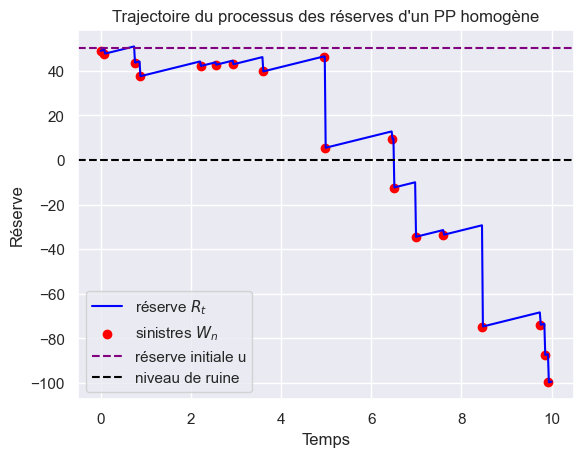

In [16]:
plt.plot(t,reserve,color="blue",label="réserve $R_t$")
plt.scatter(instants_sinistres,u+c*instants_sinistres-np.cumsum(montants_sinistres),
            color="red",marker="o",label="sinistres $W_n$")
plt.axhline(y=u,color="purple",linestyle="dashed",label="réserve initiale u")
plt.axhline(y=0,color="black",linestyle="dashed",label="niveau de ruine")
plt.xlabel("Temps")
plt.ylabel("Réserve")
plt.title("Trajectoire du processus des réserves d'un PP homogène")
plt.legend()
plt.show()

On s’intéresse désormais au risque de ruine lorsque le coefficient de chargement est strictement positif, et on
cherche à calibrer le capital initial u et le montant c des primes pour limiter le risque de ruine.

In [17]:
T = 10
u = 1000
c = 50
lambda_max = 3
beta = 100

In [18]:
def lambda_t(t): # la fonction doit être continue, bornée
    return 1+np.sin(t)

def processus_thinning(lambda_max, T):
    instants = []
    t = 0
    while t<T:
        t += np.random.exponential(scale=1/lambda_max)
        if t>=T:
            break
        if np.random.uniform(0,1)<lambda_t(t)/lambda_max:
            instants.append(t)
    return np.array(instants)
instants_sauts = processus_thinning(lambda_max,T)

In [19]:
remboursements = np.random.exponential(scale=beta, size=len(instants_sauts))
t = np.linspace(0, T, 500)
reserve = u+c*t
for t_sinistre, montant in zip(instants_sauts,remboursements):
    reserve[t>=t_sinistre] = reserve[t>=t_sinistre]-montant

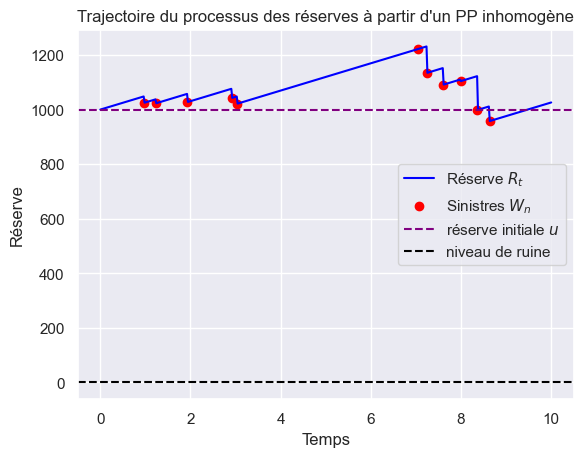

In [20]:
plt.plot(t,reserve,color="blue",label="Réserve $R_t$")
plt.scatter(instants_sauts,u+c*instants_sauts-np.cumsum(remboursements),color="red",marker="o",label="Sinistres $W_n$")
plt.axhline(y=u,color="purple",linestyle="dashed",label="réserve initiale $u$")
plt.axhline(y=0,color="black",linestyle="dashed",label="niveau de ruine")
plt.xlabel("Temps")
plt.ylabel("Réserve")
plt.title("Trajectoire du processus des réserves à partir d'un PP inhomogène")
plt.legend()
plt.show()

In [21]:
u = 1
c = 2
lambda_sinistres = 1
beta = 2/3
T = 100
simul = 10000

def test_ruine(T,u,c,lambda_sinistres,beta):
    instants = np.cumsum(np.random.exponential(
        scale=1/lambda_sinistres,size=int(T*lambda_sinistres*1.5)))
    instants = instants[instants<T]
    sinistres =np.random.exponential(scale=1/beta, size=len(instants))
    reserves = u+c*instants-np.cumsum(sinistres)
    return np.any(reserves<0)

In [22]:
ruine = sum(test_ruine(T,u,c,lambda_sinistres,beta) for _ in range(simul))/simul
psi_0 = lambda_sinistres/(beta*c)
R = beta-lambda_sinistres/c
prob_ruine_theorique = psi_0*np.exp(-R*u)
print("Probabilité de ruine théorique : ",prob_ruine_theorique)
print("Probabilité de ruine estimée : ",ruine)

Probabilité de ruine théorique :  0.6348612936679606
Probabilité de ruine estimée :  0.6381


Cela nous montre que les résulats obtenus en démonstration sont bons. Mais il y a plusieurs nuances :

La probabilité de ruine estimée par simulation Monte Carlo et celle obtenue via la formule de Lundberg présentent souvent des similitudes.
Lorsque le nombre de simulations est très grand, l'estimation converge vers la valeur théorique, validant l'approche probabiliste du modèle.

La formule de Lundberg est basée sur une approximation asymptotique, ce qui peut conduire à une sous-estimation du risque réel lorsque les sinistres sont très extrêmes.

Si le capital initial est faible, la simulation peut montrer une ruine plus rapide que prévu théoriquement, car certains scénarios rares mais impactants sont capturés par l'échantillonnage.
Du coup, on a testé à la fois un capital initial faible et fort et on a en effet une décroissance très importante des réserves de la compagnie d'assurance lorsque le capital initial est faible.

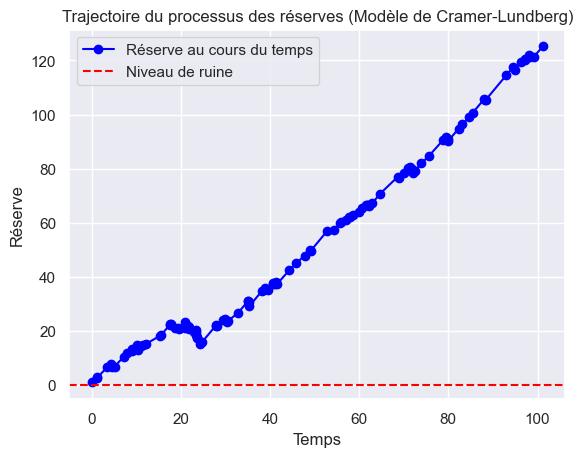

In [23]:
temps = [0]
reserves = [u]
reserve_actuelle = u
while temps[-1]<T and reserve_actuelle>0:
    temps.append(temps[-1]+np.random.exponential(scale=1/lambda_sinistres))
    reserve_actuelle += c*(temps[-1]-temps[-2])-np.random.exponential(scale=beta)
    reserves.append(reserve_actuelle)

plt.plot(temps,reserves,marker="o",linestyle="-",color="blue",label="Réserve au cours du temps")
plt.axhline(y=0,color="red",linestyle="dashed",label="Niveau de ruine")
plt.xlabel("Temps")
plt.ylabel("Réserve")
plt.title("Trajectoire du processus des réserves (Modèle de Cramer-Lundberg)")
plt.legend()
plt.show()

## Processus de Poisson homogène 

Les sinistres arrivent dans des intervalles aléatoires mais de façon stable, le risque est prévisible et suit une loi de Poisson.
La réserve évolue de manière régulière et la ruine suit une progression prévisible.

## Processus de Poisson inhomogène

Les sinistres ont une plus grande intensité à certaines périodes.
Augmente la complexité du modèle, car le processus de ruine devient moins linéaire et plus chaotique.
La ruine peut être très rapide et incertaine, ce qui exige capital initial important.